In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import random
import gc
import os
import datetime
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

pd.set_option('max_rows', 9999)
pd.set_option('max_columns', 9999)

Half_Half_LightGBM Training

In [22]:
class Trainer:
    def __init__(self, importance_df, model_type='lgb', use_feature_num=None):
        self.model_type = model_type
        
        if use_feature_num is not None:
            self.features = importance_df['feature'][:feature_num].tolist()
        else:
            self.features = None
            
    def train_half(self, X_train, y_train, params, num_boost_round, early_stopping_rounds, verbose=200):
        
        if self.features is None:
            self.features = X_train.columns
            
        self.features = [c for c in self.features if c not in ['M']]
            
        self.X_train = X_train[self.features]
        self.y_train = y_train
        
        if self.model_type == 'lgb':
            print('LightGBM Model Creating...')
            d_half_1 = lgb.Dataset(self.X_train[:int(self.X_train.shape[0] / 2)], 
                                   label=self.y_train[:int(X_train.shape[0] / 2)])
            d_half_2 = lgb.Dataset(self.X_train[int(self.X_train.shape[0] / 2):], 
                                   label=self.y_train[int(X_train.shape[0] / 2):])

            print("Building model with first half and validating on second half:")
            self.model_1 = lgb.train(params, train_set=d_half_1, num_boost_round=num_boost_round, 
                                     valid_sets=[d_half_1, d_half_2], verbose_eval=verbose, 
                                     early_stopping_rounds=early_stopping_rounds)
            
            print('')
            print("Building model with second half and validating on first half:")
            self.model_2 = lgb.train(params, train_set=d_half_2, num_boost_round=num_boost_round, 
                                     valid_sets=[d_half_2, d_half_1], verbose_eval=verbose, 
                                     early_stopping_rounds=early_stopping_rounds)
            
        elif self.model_type == 'cat':
            print('CatBoost Model Creating...')
            cat_features_index = np.where(self.X_train.dtypes == 'category')[0]
            d_half_1 = Pool(self.X_train[:int(self.X_train.shape[0] / 2)], 
                            label=self.y_train[:int(X_train.shape[0] / 2)],
                            cat_features=cat_features_index)
            d_half_2 = Pool(self.X_train[int(self.X_train.shape[0] / 2):], 
                            label=self.y_train[int(X_train.shape[0] / 2):],
                            cat_features=cat_features_index)
            
            params['iterations'] = num_boost_round
            print("Building model with first half and validating on second half:")
            model_1 = CatBoostRegressor(**params)
            model_1.fit(d_half_1, eval_set=d_half_2, use_best_model=True,
                        early_stopping_rounds=early_stopping_rounds,
                        verbose=verbose)
            
            print('')
            print("Building model with second half and validating on first half:")
            model_2 = CatBoostRegressor(**params)
            model_2.fit(d_half_2, eval_set=d_half_1, use_best_model=True,
                        early_stopping_rounds=early_stopping_rounds,
                        verbose=verbose)
            
        
        return (self.model_1, self.model_2)
    
    def get_feature_importance(self):
        df_fimp_1 = pd.DataFrame()
        df_fimp_1["feature"] = self.X_train.columns.values
        if self.model_type == 'lgb':
            df_fimp_1["importance"] = self.model_1.feature_importance()
        elif self.model_type == 'cat':
            df_fimp_1["importance"] = self.model_1.get_feature_importance()
        df_fimp_1["half"] = 1

        df_fimp_2 = pd.DataFrame()
        df_fimp_2["feature"] = self.X_train.columns.values
        if self.model_type == 'lgb':
            df_fimp_2["importance"] = self.model_2.feature_importance()
        elif self.model_type == 'cat':
            df_fimp_2["importance"] = self.model_2.get_feature_importance()
        df_fimp_2["half"] = 2

        df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

        plt.figure(figsize=(14, int(len(self.X_train.columns) * 0.2)), facecolor='w')
        sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
        plt.title("LightGBM Feature Importance")
        plt.tight_layout()
        plt.show()
        
        del df_fimp_1, df_fimp_2, df_fimp
        gc.collect()

In [23]:
# config
train_pkl_path = '../input/prep_train_20191118.pkl'
test_pkl_path = '../input/prep_test_20191118.pkl'
importance_path = '../Importance/importance_20191118.csv'
model_type = 'lgb'

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.02,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

num_boost_round = 100
early_stopping_rounds = 50
num_feature = None
verbose = 10

In [24]:
%%time
# Training
# Data Loading
with open(train_pkl_path, 'rb') as f:
    train = pickle.load(f)

importance_df = pd.read_csv(importance_path)
# Train Model
trainer = Trainer(importance_df=importance_df, model_type=model_type, use_feature_num=num_feature)
models = trainer.train_half(train[0], train[1], params, num_boost_round, early_stopping_rounds, verbose)

del train, importance_df
gc.collect()

LightGBM Model Creating...
Building model with first half and validating on second half:
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 1.90927	valid_1's rmse: 1.91339
[20]	training's rmse: 1.7617	valid_1's rmse: 1.78562
[30]	training's rmse: 1.63849	valid_1's rmse: 1.6826
[40]	training's rmse: 1.53818	valid_1's rmse: 1.59987
[50]	training's rmse: 1.45692	valid_1's rmse: 1.53652
[60]	training's rmse: 1.3882	valid_1's rmse: 1.48438
[70]	training's rmse: 1.33124	valid_1's rmse: 1.44122
[80]	training's rmse: 1.27876	valid_1's rmse: 1.40224
[90]	training's rmse: 1.23592	valid_1's rmse: 1.37214
[100]	training's rmse: 1.19335	valid_1's rmse: 1.34274
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 1.19335	valid_1's rmse: 1.34274

Building model with second half and validating on first half:
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 1.90489	valid_1's rmse: 1.93774
[20]	training's rmse: 1.76	vali

533

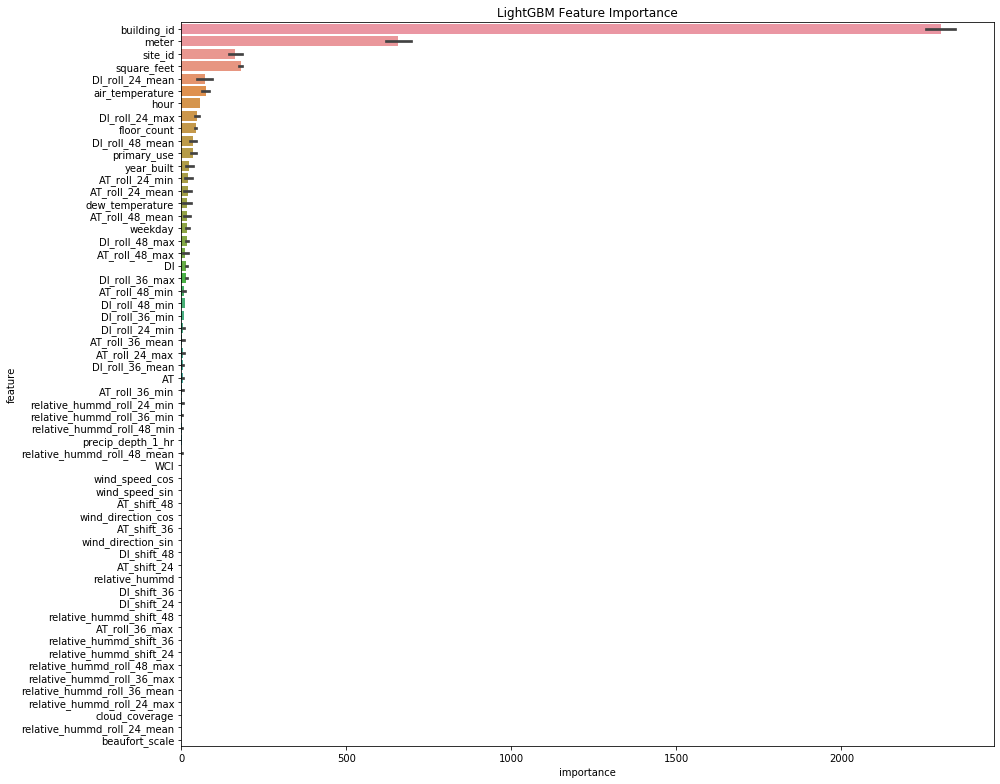

In [25]:
trainer.get_feature_importance()

Preparing test data 

Preparing test data with same features as train data.

In [29]:
%%time
# Predict & Submission
# Data Loading
with open(test_pkl_path, 'rb') as f:
    test = pickle.load(f)

pred = np.zeros(len(test[1]))
for model in models:
    if trainer.model_type == 'lgb':
        pred += np.expm1(model.predict(test[0], num_iteration=model.best_iteration)) / int(len(models))
    elif trainer.model_type == 'cat':
        pred += np.expm1(model.predict(test[0])) / int(len(models))
    
today = datetime.datetime.now().strftime('%Y%m%d')
submission = pd.DataFrame({"row_id": test[1], "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv(f"../Output/submission_from_nb_{trainer.model_type}_{today}.csv", index=False)
print("DONE")

DONE
